## Preprocess data
Read adata of ATAC-seq and RNA-seq and save them as sparse data and annotations.

In [1]:
from scipy.io import mmwrite
import anndata 
import os
out_dir = '../../output'
os.makedirs(f'{out_dir}/infer/figr/grn/', exist_ok=True)
os.makedirs(f'{out_dir}/infer/figr/grn/', exist_ok=True)

### ATAC-seq

In [12]:
# python
adata_atac = anndata.read(f'{out_dir}/scATAC/adata_atac.h5ad')
# save sparse matrix
mmwrite(f"{out_dir}/scATAC/X_matrix.mtx", adata_atac.X)
# save annotation
annotation_peak = adata_atac.var.reset_index().location.str.split(':', expand=True)
annotation_peak.columns = ['seqname', 'ranges']
annotation_peak['strand'] = '+' 
annotation_peak.to_csv(f"{out_dir}/scATAC/annotation_peak.csv")

annotation_cells = adata_atac.obs.reset_index()
annotation_cells.to_csv(f"{out_dir}/scATAC/annotation_cells.csv")

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


### RNA-seq

In [7]:
adata_rna = anndata.read(f'{out_dir}/scRNA/adata_rna.h5ad')
# save sparse matrix
mmwrite(f"{out_dir}/scRNA/X_matrix.mtx", adata_rna.X)
# save annotation
annotation_gene = adata_rna.var.reset_index()
annotation_gene.to_csv(f"{out_dir}/scRNA/annotation_gene.csv")

annotation_cells = adata_rna.obs.reset_index()[['obs_id','cell_type']]
annotation_cells.to_csv(f"{out_dir}/scRNA/annotation_cells.csv")

/root/anaconda3/envs/py10_2/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## cell-topic probability scores 

In [3]:
import pickle
cistopic_obj = pickle.load(
            open(f'{out_dir}/scenicplus/_scATAC/cistopic_obj.pkl', 'rb'))
# get cell topic association 
cell_topic = cistopic_obj.selected_model.cell_topic.T
cell_names = cistopic_obj.cell_data.obs_id.values

cell_topic.index = cell_names
# remove donor name from the index
# cell_topic.index = cell_topic.reset_index()['index'].apply(lambda name: name.split('__')[0])

In [5]:
cell_topic.to_csv(f'{out_dir}/infer/figr/cell_topic.csv')

# Pipeline of FigR

In [2]:
%load_ext rpy2.ipython

In [11]:
%%R -i out_dir
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)

library(dplyr)
library(FNN)
library(chromVAR)
library(doParallel)
library(BuenColors)
library(FigR)
library(BSgenome.Hsapiens.UCSC.hg38)

## Load atac-seq and create summarizedexperiment

In [13]:
%%R 
X <- readMM(paste0(out_dir, "/scATAC/X_matrix.mtx"))
X <- t(X)
annotation_peak <- read.csv(paste0(out_dir, "/scATAC/annotation_peak.csv"), row.names = 1)
annotation_cells <- read.csv(paste0(out_dir, "/scATAC/annotation_cells.csv"), row.names = 1)

# Filter out entries where seqname is 'chr10'
filter_indices <- grepl("^chr", annotation_peak$seqname)
annotation_peak_filtered <- annotation_peak[filter_indices, ]

# Filter the rows in X
X_filtered <- X[filter_indices, ]

# Create the SummarizedExperiment object with the filtered data
atac <- SummarizedExperiment(assays = list(counts = X_filtered), 
                             rowRanges = GRanges(annotation_peak_filtered$seqname,
                             IRanges(annotation_peak_filtered$ranges)), 
                             colData = DataFrame(annotation_cells))
colnames(atac) <- annotation_cells$obs_id    

dim(atac) #peaks*cells

saveRDS(atac, paste0(out_dir, "/scATAC/atac.rds"))


### Load RNA-seq and create sparsematrix

In [11]:
%%R 
XX <- readMM(paste0(out_dir, "/scRNA/X_matrix.mtx"))
XX <- t(XX)
annotation_gene <- read.csv(paste0(out_dir, "/scRNA/annotation_gene.csv"), row.names = 1)
annotation_cells <- read.csv(paste0(out_dir, "/scRNA/annotation_cells.csv"), row.names = 1)

rna <- as(XX, "CsparseMatrix")
rownames(rna) <- annotation_gene$location
colnames(rna) <- annotation_cells$obs_id

# Remove genes with zero expression across all cells
rna <- rna[Matrix::rowSums(rna)!=0,]

dim(rna) # genes*cells

saveRDS(rna, paste0(out_dir, "/scRNA/rna.rds"))


[1] 22787 25551


## load cell topic probabilities and create cell-cluster matrix


In [6]:
%%R -i out_dir
n_topics = 48
cell_topic <- read.csv(paste0(out_dir, "/infer/figr/cell_topic.csv"), row.names = 1)
print(dim(cell_topic))
# Derive cell kNN using this
cellkNN <- get.knn(cell_topic, k=n_topics)$nn.index
rownames(cellkNN) <- rownames(cell_topic)
print(dim(cellkNN))

saveRDS(cellkNN, paste0(out_dir, "/infer/figr/cellkNN.rds"))

[1] 25551    48
[1] 25551    48


## Step1: Peak-gene association testing

In [ ]:
# /beegfs/desy/user/nourisaj/R/figr/4.2.3/bin/Rscript

In [8]:
%%R 
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)

library(dplyr)
library(FNN)
library(chromVAR)
library(doParallel)
library(BuenColors)
library(FigR)
library(BSgenome.Hsapiens.UCSC.hg38)

out_dir <- '../../output'

atac = readRDS(paste0(out_dir, "/scATAC/atac.rds"))
rna  = readRDS(paste0(out_dir, "/scRNA/rna.rds"))
cisCorr <- FigR::runGenePeakcorr(ATAC.se = atac,
                           RNAmat = rna,
                           genome = "hg38", # One of hg19, mm10 or hg38 
                           nCores = 40,
                           p.cut = NULL, # Set this to NULL and we can filter later
                           n_bg = 100)
write.csv(cisCorr, paste0(out_dir, "/infer/figr/grn/cisCorr.csv"), row.names = TRUE)

Matrix object input detectedCentering counts for cells sequentially in groups of size  1000  ..

Computing centered counts for cells:  1  to  1000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  1001  to  2000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  2001  to  3000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  3001  to  4000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  4001  to  5000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  5001  to  6000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  6001  to  7000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  

Exception ignored from cffi callback <function _consolewrite_ex at 0x7f01713f40d0>:
Traceback (most recent call last):
  File "/root/anaconda3/envs/scenicplus/lib/python3.8/site-packages/rpy2/rinterface_lib/callbacks.py", line 130, in _consolewrite_ex
    @ffi_proxy.callback(ffi_proxy._consolewrite_ex_def,
KeyboardInterrupt: 


  |=======================================================| 100%, Elapsed 00:08
Finished!

Time Elapsed:  7.81739735603333 secs 

Computing background correlations ..
  |=====================================================      |  90%, ETA 00:01

## Step 2: create DORCs and smooth them 

In [ ]:
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)

library(dplyr)
library(FNN)
library(chromVAR)
library(doParallel)
library(BuenColors)
library(FigR)
library(BSgenome.Hsapiens.UCSC.hg38)

out_dir <- '../../output'

cisCorr = read.csv(paste0(out_dir, "/infer/figr/grn/cisCorr.csv"))
cisCorr.filt <- cisCorr %>% filter(pvalZ <= 0.05)

atac = readRDS(paste0(out_dir, "/scATAC/atac.rds"))
rna  = readRDS(paste0(out_dir, "/scRNA/rna.rds"))

allGenes = unique(cisCorr.filt$Gene) 
dorcMat <- getDORCScores(ATAC.se = atac, # Has to be same SE as used in previous step
                         dorcTab = cisCorr.filt,
                         geneList = allGenes,
                         nCores = 4)

cellkNN = readRDS(paste0(out_dir, "/infer/figr/cellkNN.rds"))
# Smooth dorc scores using cell KNNs (k=n_topics)
n_topics = 48
dorcMat.s <- smoothScoresNN(NNmat = cellkNN[,1:n_topics], mat = dorcMat, nCores = 4)

# Smooth RNA using cell KNNs
# This takes longer since it's all genes
RNAmat.s <- smoothScoresNN(NNmat = cellkNN[,1:n_topics], mat = rna,nCores = 4)

write.csv(cisCorr.filt, paste0(out_dir, "/infer/figr/grn/cisCorr.filt.csv"))
saveRDS(RNAmat.s, paste0(out_dir, "/infer/figr/grn/RNAmat.s.RDS"))
saveRDS(dorcMat.s, paste0(out_dir, "/infer/figr/grn/dorcMat.s.RDS"))

## TF-gene associations
Do not run this locally.

In [ ]:
%%R 
options(digits=5, max.print=100)  # Adjust numbers as needed
set.seed(123)

library(dplyr)
library(FNN)
library(chromVAR)
library(doParallel)
library(BuenColors)
library(FigR)
library(BSgenome.Hsapiens.UCSC.hg38)

out_dir <- '../../output'

cisCorr.filt = read.csv(paste0(out_dir, "/infer/figr/grn/cisCorr.filt.csv"))
RNAmat.s = readRDS(paste0(out_dir, "/infer/figr/grn/RNAmat.s.RDS"))
dorcMat.s = readRDS(paste0(out_dir, "/infer/figr/grn/dorcMat.s.RDS"))
atac = readRDS(paste0(out_dir, "/scATAC/atac.rds"))
figR.d <- runFigRGRN(ATAC.se = atac, # Must be the same input as used in runGenePeakcorr()
                     dorcTab = cisCorr.filt, # Filtered peak-gene associations
                     genome = "hg38",
                     dorcMat = dorcMat.s,
                     rnaMat = RNAmat.s, 
                     nCores = 40)
write.csv(figR.d, paste0(out_dir, "/infer/figr/grn/figR.d.csv"))

## Evaluation of results

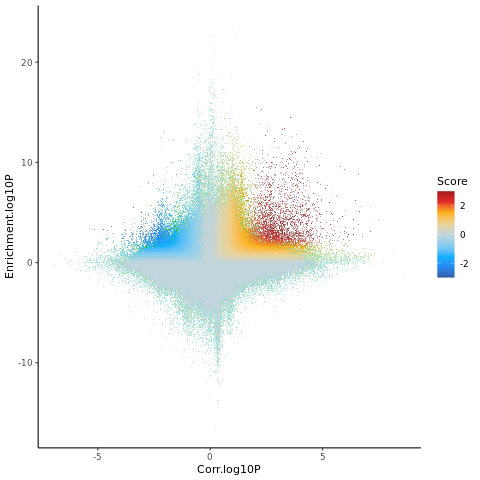

In [14]:
%%R 
figR.d = read.csv(paste0(out_dir, "/infer/figr/grn/figR.d.csv"))

figR.d %>% 
  ggplot(aes(Corr.log10P,Enrichment.log10P,color=Score)) + 
  ggrastr::geom_point_rast(size=0.01,shape=n_topics) + 
  theme_classic() + 
  scale_color_gradientn(colours = jdb_palette("solar_extra"),limits=c(-3,3),oob = scales::squish,breaks=scales::breaks_pretty(n=3))

In [ ]:
%%R 
rankDrivers(figR.d,rankBy = "meanScore",interactive = FALSE)

## Process the results and output final GRN

In [16]:
import pandas as pd
import numpy as np

### GRN 

In [18]:
figr_grn = pd.read_csv(f'{out_dir}/infer/figr/grn/figR.d.csv', index_col=0)
# filter based on enrichment 
figr_grn = figr_grn[figr_grn['Enrichment.P']<0.05]
# filter bsaed on correlatoon
figr_grn = figr_grn[figr_grn['Corr.P']<0.05]
# filter thoes that are 0 score 
figr_grn = figr_grn[figr_grn.Score!=0]
# subset columns
figr_grn = figr_grn[['Motif', 'DORC', 'Score']]
figr_grn = figr_grn.reset_index(drop=True)
figr_grn.columns = ['source', 'target','weight']
figr_grn.to_csv(f'{out_dir}/infer/figr/grn/grn.csv')

In [21]:
figr_grn.target.unique().shape

(7804,)

### Peak-gene

In [33]:
# load peak-gene association after filtering for significant
peak_gene_figr = pd.read_csv(f'{out_dir}/infer/figr/grn/cisCorr.filt.csv', index_col=0)
peak_gene_figr_n = peak_gene_figr.groupby('Gene').apply(lambda df:df['PeakRanges'].shape[0])
np.max(peak_gene_figr_n.values), np.median(peak_gene_figr_n.values)
peak_gene_figr.to_csv(f'{out_dir}/infer/figr/grn/peak_gene.csv')
print('In the peak-gene associations: number of  CIS ', peak_gene_figr.PeakRanges.unique().shape[0], ', gene ', peak_gene_figr.Gene.unique().shape[0])
print('number of DORC genes ', (peak_gene_figr_n.values >= 10).sum())

In the peak-gene associations: number of  CIS  20103 , gene  8249
number of DORC genes  180


## DORC genes

[1] 180


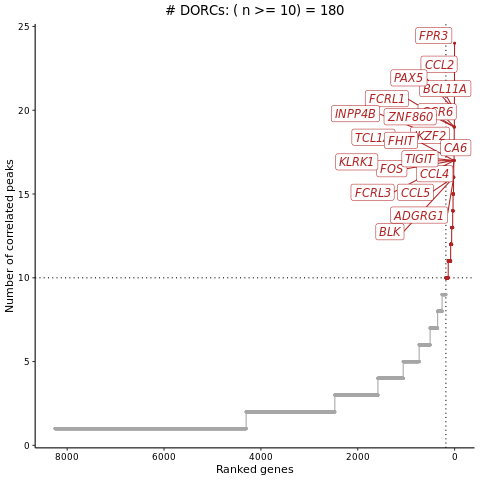

In [32]:
%%R 
out_dir
cisCorr.filt = read.csv(paste0(out_dir, "/infer/figr/grn/cisCorr.filt.csv"))
dorcGenes <- dorcJPlot(dorcTab = cisCorr.filt,
                         cutoff = 10, # No. sig peaks needed to be called a DORC
                         labelTop = 20,
                         returnGeneList = TRUE, # Set this to FALSE for just the plot
                         force=2)
# # Unfiltered
numDorcs <- cisCorr.filt %>% group_by(Gene) %>% tally() %>% arrange(desc(n))
length(dorcGenes)